# Demo pipeline
## Preprocessing, Model Reconstruction and Model Merging

# Setup

In [1]:
from pathlib import Path
from natsort import natsorted

from cityslam.videointerface import downloader
from cityslam.preprocessing import preprocessing, transitions, create_img_list
from cityslam.mapping import reconstruction
from cityslam.localization import merge
from cityslam.graph.utils import find_graphs, get_graphs, draw_super, transform_models, get_tf_filter_view

# setup necessary paths
base_dir = Path('./demo')

datasets = base_dir / 'datasets'
outputs = base_dir / 'outputs'

videos = datasets / 'videos'
images = datasets / 'images'
queries = datasets / 'queries'
video_transitions = datasets / 'transitions'
video_transitions_cropped = datasets / 'transitions_cropped'
image_list = datasets / 'image_list'

models = outputs / 'models'
output_merge = outputs / 'merge'
output_graph = outputs / 'graph'

overwrite = False
fps = 2

# Videos to download, we skip the video interface as we only want a short demo run
video_ids = ['gTHMvU3XHBk', 'TZIHy1cZJ-U']

/Users/theodorforgaard/miniconda3/envs/icityslam/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the demo videos

In [2]:
downloader.main(videos, video_ids, format="bv", overwrite=overwrite)

[youtube] gTHMvU3XHBk: Downloading webpage
[youtube] gTHMvU3XHBk: Downloading android player API JSON
[youtube] gTHMvU3XHBk: Downloading MPD manifest
[youtube] gTHMvU3XHBk: Downloading MPD manifest
[info] gTHMvU3XHBk: Downloading 1 format(s): 248
[download] demo/datasets/videos/Test Walk 1 Zürich [gTHMvU3XHBk].webm has already been downloaded
[download] 100% of 5.53MiB
[youtube] TZIHy1cZJ-U: Downloading webpage
[youtube] TZIHy1cZJ-U: Downloading android player API JSON
[info] TZIHy1cZJ-U: Downloading 1 format(s): 313
[download] demo/datasets/videos/test walk 2 Zürich [TZIHy1cZJ-U].webm has already been downloaded
[download] 100% of 76.67MiB


## Extract image frames

In [3]:

image_folders = preprocessing.main(
    videos, images, video_ids, overwrite=overwrite, fps=fps)

[2022/06/13 23:08:09 cityslam INFO] extracting frames from video: test walk 2 Zürich [TZIHy1cZJ-U].webm using fps: 2
[2022/06/13 23:08:09 cityslam INFO] extracting frames from video: Test Walk 1 Zürich [gTHMvU3XHBk].webm using fps: 2
[2022/06/13 23:08:09 cityslam INFO] frames already extracted for video: Test Walk 1 Zürich [gTHMvU3XHBk].webm
[2022/06/13 23:08:09 cityslam INFO] frames already extracted for video: test walk 2 Zürich [TZIHy1cZJ-U].webm


## Detect cuts

In [4]:
path_to_weights = Path('./cityslam/preprocessing')

transitions.main(
    videos, video_ids, path_to_weights, video_transitions, video_transitions_cropped, 5*60, 10, fps, 0.5, overwrite_cuts=True)


using device cpu
Already found transitions for video Test Walk 1 Zürich [gTHMvU3XHBk]
video fps: 29.793
Already found transitions for video test walk 2 Zürich [TZIHy1cZJ-U]
video fps: 30.0


In [5]:
create_img_list.create_img_list(video_transitions_cropped, images, image_list)


demo/datasets/transitions_cropped/TZIHy1cZJ-U_transitions_cropped.txt
0 82
demo/datasets/transitions_cropped/gTHMvU3XHBk_transitions_cropped.txt
0 41


In [6]:
# Find all scenes
scene_ids = [str(p.relative_to(image_list)).split("_images")[0] for p in natsorted(list(image_list.glob("**/*_images.txt")))]
print(f"Total scenes: {len(scene_ids)}")

# Filter out the ones that are already done
scene_ids = [scene_id for scene_id in scene_ids if next((models / scene_id).glob("**/images.bin"), None) is None]
print(f"Scenes left: {len(scene_ids)}")

# Run model reconstruction
for scene_id in scene_ids:
    scene_image_list = Path(image_list) / f"{scene_id}_images.txt"

    model = reconstruction.main(
        images, scene_image_list, models, video_id=scene_id, window_size=6, num_loc=6, pairing='sequential+retrieval', run_reconstruction=True, overwrite=False)


Total scenes: 2
Scenes left: 0


## Merge the reconstructed models

In [7]:
# Set the min inlier threshold lower for small demo run
abs_pose_conf = {'min_inliers_transformations' : 5}

merge.main(models, output_merge, abs_pose_conf=abs_pose_conf, visualize=True)

[2022/06/13 23:08:10 cityslam INFO] trying to merge gTHMvU3XHBk/part00 with TZIHy1cZJ-U/part00
[2022/06/13 23:08:10 cityslam INFO] skipping retrieval, already found
[2022/06/13 23:08:10 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2022/06/13 23:08:10 hloc INFO] Skipping the matching.
[2022/06/13 23:08:10 hloc.utils.parsers INFO] Imported 6 images from gTHMvU3XHBk__part00_queries_with_intrinsics.txt
[2022/06/13 23:08:10 hloc INFO] Reading the 3D model...
[2022/06/13 23:08:10 hloc INFO] Starting localization...
100%|██████████| 6/6 [00:00<00:00, 18.74it/s]
[2022/06/13 23:08:11 hloc INFO] Localized 6 / 6 images.
[2022/06/13 23:08:11 hloc INFO] Writing poses to demo/outputs/merge/gTHMvU3XHBk/part00/TZIHy1cZJ-U/part00/Merge_hloc_superpoint+superglue_netvlad.txt...
[2022/06/13 23:08:11 hloc INFO] Writing logs to demo/outputs/merge/gTHMvU3XHBk/part

## Build graph, apply transformations and visualize

#### NB: in case of nbformat error, run `python -m pip install --upgrade nbformat`

Found 2 nodes
['gTHMvU3XHBk__part00', 'TZIHy1cZJ-U__part00']


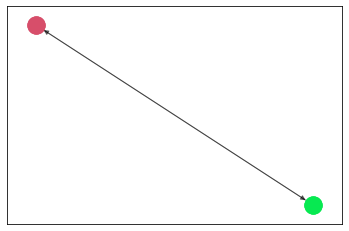

In [11]:
output_graph.mkdir(exist_ok=True, parents=True)

# Super graph containing all nodes and all found transformations
super_graph = find_graphs(models, output_merge)

# Split super graph up into a list of connected graphs
maps = get_graphs(super_graph)

print(f"Found {len(super_graph.nodes)} nodes")
print(super_graph.nodes)

# Draw all nodes and found transformations (as edges)
draw_super(get_tf_filter_view(super_graph), models)


transform_models(models, output_graph, get_tf_filter_view(maps[0]), visualize=True, save=True, points=True)